In [1]:
%matplotlib inline
import os
import numpy             as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas            as pd
from   pathlib           import Path

import setup_bmss                as lab
import BMSS.models.model_handler as mh
import BMSS.models.settings_handler  as sh
import BMSS.models.setup_cf      as sc
import BMSS.icanalysis           as ac
import BMSS.curvefitting         as cf
import BMSS.traceanalysis        as ta
import BMSS.models.setup_sim     as sm
import BMSS.simulation           as sim
import BMSS.models.setup_sen     as ss
import BMSS.sensitivityanalysis  as sn
import BMSS.models.setup_sg         as ssg
import BMSS.models.ia_results       as ir
import BMSS.strike_goldd_simplified as sg
import BMSS.sbml                    as sb

plt.close('all')
plt.rcParams['figure.figsize'] = [12, 7]

Connected to MBase_models, UBase_models
Connected to MBase_settings, UBase_settings


In [2]:
def read_data(filename):
    '''Read experimental data and process the data into proper format (customized).
    Return: mean and standard deviation data in dict
    '''
    state     = 'Fluor/OD'
    data_mu   = {}
    data_sd   = {}
    state_sd  = {}
    tspan     = None
    df        = pd.read_csv(filename)
    scenarios = []
    
    init      = {}
    
    for column in df.columns:
        if 'std' in column:
            continue
        elif 'Time' in column:
            scenarios = [column] + scenarios
        else:
            scenarios.append(column)
      
    #Set up data_mu, data_sd, init, tspan
    for model_num in range(1, 4):
        data_mu[model_num] = {state:{}}
        data_sd[model_num] = {state:{}}
        init[model_num]    = {}
        
        for i in range(len(scenarios)):
            scenario = scenarios[i]
            
            if i == 0:
                data_mu[model_num][state][i] = df[scenario].values
                data_sd[model_num][state][i] = df[scenario].values
                tspan                        = df[scenario].values 
            else:
                data_mu[model_num][state][i] = df[scenario].values *1e-6/(18.814*30)
                data_sd[model_num][state][i] = df[scenario + 'std'].values *1e-6/(18.814*30)
                
                #Specific to the model in question
                init_val           = data_mu[model_num][state][i][0]              
                init[model_num][i] = {state:init_val}
    
    #Set up state_sd
    df_sd           = df[[scenario + 'std' for scenario in scenarios if 'Time' not in scenario]]
    state_sd[state] = df_sd.mean().mean()*1e-6/(18.814*30)
    
    #Add scenarios for reference    
    data_mu[1]['Fluor/OD'][-1] = scenarios
    data_sd[1]['Fluor/OD'][-1] = scenarios
    
    return data_mu, data_sd, init, state_sd, tspan

In [3]:
def modify_params(init_values, params, model_num, scenario_num, segment):
    #Always use a copy and not the original
    new_params = params.copy()
    
    #Change value of inducer based on scenario_num
    if scenario_num == 1:
        new_params[-2] = 1
        new_params[-1] = 1
    elif scenario_num == 2:
        new_params[-2] = 0
        new_params[-1] = 1
    elif scenario_num == 3:
        new_params[-2] = 1
        new_params[-1] = 0
    else:
        new_params[-2] = 0
        new_params[-1] = 0

    return new_params

## Curve-Fitting/Parameter Estimation

### Set Up Core Models
- Read model files with **from_config**

In [4]:
#Set up core models and sampler arguments
model_files = ['LogicGate_OR_Double.ini',
               'LogicGate_OR_Double_Degrade_Delay.ini',
               'LogicGate_OR_Double_Delay_Degrade_ResCompete.ini'
               ]

#List of model dicts
user_core_models = {}

for filename in model_files:
    core_model                    = mh.from_config(filename)
    system_type                   = core_model['system_type']
    user_core_models[system_type] = core_model

print('User core models', list(user_core_models.keys()))

User core models ['LogicGate, OR, Double', 'LogicGate, OR, Double, Degrade, Delay', 'LogicGate, OR, Double, Delay, Degrade, ResCompete']


### Preprocessing
- Read data in dictionaries
- Get simulation settings with get_sampler_args
- Update simulation settings for model 

In [5]:
data_file = Path.cwd()/'data'/'LogicGate_ORAraAtcTop10d37M9.csv'
data_mu, data_sd, init, state_sd, tspan = read_data(data_file)

sampler_args, config_data = sc.get_sampler_args('cf_settings.ini', user_core_models=user_core_models)

sampler_args['data'] = data_mu

for model_num in sampler_args['models']:
    sampler_args['models'][model_num]['tspan'] = [tspan]
    sampler_args['models'][model_num]['sd']    = state_sd
    sampler_args['models'][model_num]['states'][-1] = 'Fluor/OD'
    sampler_args['models'][model_num]['int_args']['modify_params'] = modify_params


## Run Sampler

In [6]:
#Run sampler
traces    = {}    
result    = cf.simulated_annealing(**sampler_args)
accepted  = result['a']
traces[1] = accepted

#Export accepted dataframe into csv file
accepted.to_csv('Output_files/accepted.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:10<00:00, 15.71it/s]


## Rank Models

In [7]:
#Rank models
table = ac.calculate_ic(data   = sampler_args['data'], 
                        models = sampler_args['models'], 
                        priors = sampler_args['priors'],
                        params = accepted
                        )

ranked_table  = ac.rank_ic(table, inplace=False)
print('Ranked AIC table:')
ranked_table.groupby('model_num').first()


Ranked AIC table:


,row,ic value,Evidence,d(ic value)
model_num,,,,
1,536,980.660146,No support,617.944484
2,535,867.146711,No support,504.431049
3,536,362.715662,Substantial support,0.000000


## Plot Results

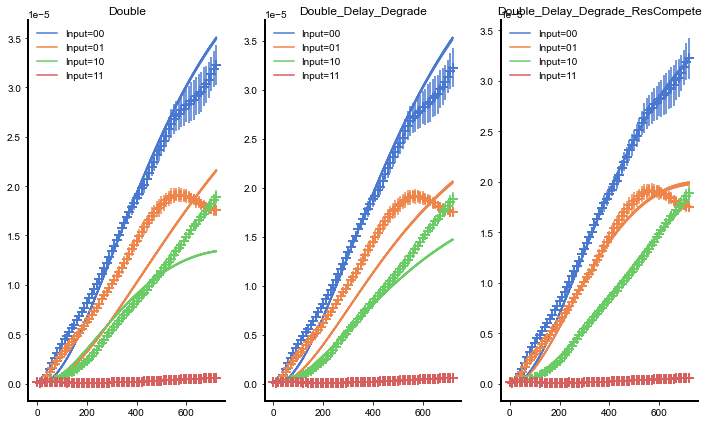

In [32]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 7]

#Plot results
plot_index  = {1: ['Fluor/OD'], 
               2: ['Fluor/OD'], 
               3: ['Fluor/OD']
               }
titles      = {1: {'Fluor/OD': 'Double'}, 
               2: {'Fluor/OD': 'Double_Delay_Degrade'}, 
               3: {'Fluor/OD': 'Double_Delay_Degrade_ResCompete'}
                  }
labels      = {1: {1: 'Input=00', 2: 'Input=01', 3: 'Input=10', 4: 'Input=11'},
               2: {1: 'Input=00', 2: 'Input=01', 3: 'Input=10', 4: 'Input=11'},
               3: {1: 'Input=00', 2: 'Input=01', 3: 'Input=10', 4: 'Input=11'}
               }
legend_args = {'loc': 'upper left'}

#Plot the results into two figures for better visualization
fig1, AX1 = plt.subplots(1, 3)
# fig2, AX2 = plt.subplots(1, 3)
AX        = {1: {'Fluor/OD' : AX1[0]},
             2: {'Fluor/OD' : AX1[1]},
             3: {'Fluor/OD' : AX1[2]},
             }

figs, AX  = cf.plot(posterior   = accepted.iloc[-20::2], 
                    models      = sampler_args['models'], 
                    guess       = sampler_args['guess'],
                    data        = data_mu,
                    data_sd     = data_sd,
                    plot_index  = plot_index,
                    labels      = labels,
                    titles      = titles,
                    legend_args = legend_args,
                    AX          = AX
                    )

## Extract and Export Best Parameter Set/Model

In [9]:
#Export the ranked table into csv file inside the output folder
ranked_table.to_csv('ranked_table.csv') 

best           = ranked_table.iloc[0]
best_row_index = best['row']
best_model_num = best['model_num']

In [10]:
print(best_model_num)

3


In [11]:
print(accepted.loc[best_row_index])

syn_mRNA1_1    6.509358e-07
syn_mRNA2_1    5.113698e-07
syn_mRNA3_1    1.396446e-07
deg_mRNA_1     1.357000e-01
syn_Pep_1      6.437852e-03
deg_Pep_1      2.517480e-03
Pepmax_1       6.256052e-07
Km_1           1.297954e-01
deg_Ind_1      2.678006e-03
state1_1       0.000000e+00
state2_1       0.000000e+00
syn_mRNA1_2    7.645067e-07
syn_mRNA2_2    1.065378e-06
syn_mRNA3_2    1.215102e-07
deg_mRNA_2     1.357000e-01
syn_Pep_2      6.049957e-03
deg_Pep_2      3.474027e-03
Pepmax_2       7.282250e-07
state1_2       0.000000e+00
state2_2       0.000000e+00
syn_mRNA1_3    4.612336e-07
syn_mRNA2_3    1.144915e-06
syn_mRNA3_3    1.227336e-07
deg_mRNA_3     1.357000e-01
syn_Pep_3      7.037876e-03
deg_Pep_3      2.501058e-03
Pepmax_3       7.066333e-07
Km_3           7.100994e-02
deg_Ind_3      3.146214e-03
Ratio_3        1.539657e-01
state1_3       0.000000e+00
state2_3       0.000000e+00
Name: 536, dtype: float64


## A Posteriori Identifiability Analysis
- Plot trace of sampler
- Check if distribution stabilizes at the end of the run

In [12]:
to_skip = sampler_args['fixed_parameters'] + [p for p in sampler_args['guess'] if '_3' not in p]
trace_figs, trace_AX = ta.plot_steps(traces, 
                                     skip        = to_skip, 
                                     legend_args = legend_args,
                                     )

## Database
- Make new settings
- Add model and settings with **add_to_database**

In [13]:
new_settings                  = config_data[3]
new_settings['settings_name'] = 'bestfit'
new_settings['parameters']    = cf.get_params_for_model(models    = sampler_args['models'], 
                                                        trace     = accepted, 
                                                        model_num = best_model_num,
                                                        row_index = best_row_index
                                                        )

model        = user_core_models['LogicGate, OR, Double, Delay, Degrade, ResCompete']
if 'LogicGate, OR, Double, Delay, Degrade, ResCompete' not in mh.list_models():
    mh.add_to_database(model)
new_settings = sh.make_settings(**new_settings)
sh.add_to_database(new_settings)

Added settings bestfit


('LogicGate, OR, Double, Delay, Degrade, ResCompete', 'bestfit')

## Sensitivity Analysis

### Setting Up
- Read settings files with **get_sensitivity_args**

In [14]:
    config_data = ss.from_config('sn_settings.ini')
        
    sensitivity_args, _ = ss.get_sensitivity_args(config_data, user_core_models=user_core_models)
    
    def Pep3_yield(y, t, params):
        final_Pep3 = y[-1, -1]
        
        return final_Pep3
    
    sensitivity_args['models'][1]['int_args']['modify_params'] = modify_params
    sensitivity_args['objective'] = {1: [Pep3_yield]}

### Run Analysis

In [15]:
analysis_result, em, samples, problems = sn.analyze(**sensitivity_args)

### First Order Sensitivity

In [16]:
#Plot settings
titles   = {1: {Pep3_yield: 'Pep output'}
           }

#Plot
first_order_figs, first_order_AX = sn.plot_first_order(analysis_result, problems=problems, titles=titles,
                                                       analysis_type=sensitivity_args['analysis_type'],
                                                      )



### Second Order Sensitivity

In [17]:
sec_order_figs, sec_order_AX = sn.plot_second_order(analysis_result, problems=problems, titles=titles,
                                                    analysis_type=sensitivity_args['analysis_type'],
                                                   )
    

## A Priori Identifiability Analysis
- Get settings with get_strike_goldd_args

In [18]:
sg_args, config_data, variables = ssg.get_strike_goldd_args('sg_settings.ini', user_core_models=user_core_models)

sg_results = sg.analyze_sg_args(sg_args)

States :  [mRNA1_1, Pep1_1, mRNA2_1, Pep2_1, mRNA3_1, Pep3_1]
Outputs:  [Pep1_1, Pep2_1, Pep3_1]
Params :  [deg_mRNA_1, Pepmax_1]
Inputs :  {state1_1: 1, state2_1: 1}
ICS    :  {mRNA1_1: 0.0, Pep1_1: 0.0, mRNA2_1: 0.0, Pep2_1: 0.0, mRNA3_1: 0.0, Pep3_1: 0.0}
Equations:
-deg_mRNA_1*mRNA1_1 + state1_1*syn_mRNA1_1
-Pep1_1*deg_Pep_1 + mRNA1_1*syn_Pep_1
-deg_mRNA_1*mRNA2_1 + state2_1*syn_mRNA2_1
-Pep2_1*deg_Pep_1 + mRNA2_1*syn_Pep_1
-deg_mRNA_1*mRNA3_1 + syn_mRNA3_1*(Pep1_1 + Pep2_1)/Pepmax_1
-Pep3_1*deg_Pep_1 + mRNA3_1*syn_Pep_1
Building Oi with 2 derivatives and size (9, 8)
Time for adding one Lie derivative: 0.060964345932006836
Time for adding one Lie derivative: 0.08994793891906738
Time for building Oi: 0.1888895034790039
Checking rank for matrix with size (9, 8)
Rank 6
Time for Row Reduction: 1.044966697692871
Elim-recalc for matrix with size (9, 8)
Found [mRNA1_1, mRNA2_1, mRNA3_1]
Extending Oi
Time for adding one Lie derivative: 0.09991884231567383
Checking rank for matrix with size

In [19]:
for k, v in sg_results[1].items():
    print(k, ':', v)

mRNA1_1 : True
Pep1_1 : True
mRNA2_1 : True
Pep2_1 : True
mRNA3_1 : True
Pep3_1 : True
deg_mRNA_1 : True
Pepmax_1 : True


## Retrieval

In [20]:
mh.list_models()[:5]

['BMSS, ConstantInduction, Inducible',
 'BMSS, ConstantInduction, Inducible, MaturationTime',
 'BMSS, InducerDegradation, Inducible',
 'BMSS, InducerDegradation, Inducible, MaturationTime',
 'BMSS, DelayActivation, Inducible, ActiveTransport']

In [21]:
model = mh.quick_search('LogicGate, OR, Double, Delay, Degrade, ResCompete')
for k, v in model.items():
    print(k)
    print(v)
    print()

id
usr1

system_type
LogicGate, OR, Double, Delay, Degrade, ResCompete

states
['Inde', 'Indi', 'Ind', 'mRNA1', 'Pep1', 'mRNA2', 'Pep2', 'mRNA3', 'Pep3']

parameters
['syn_mRNA1', 'syn_mRNA2', 'syn_mRNA3', 'deg_mRNA', 'syn_Pep', 'deg_Pep', 'Pepmax', 'Km', 'deg_Ind', 'Ratio']

inputs
['state1', 'state2']

equations
['dInde = -(Inde/(Inde+Km))*Inde', 'dIndi = (Inde/(Inde+Km))*Inde', 'dInd  = -deg_Ind*Ind', 'dmRNA1 = syn_mRNA1*(Indi)*(state1) - (deg_mRNA *mRNA1)', 'dPep1 = (syn_Pep*mRNA1) - (deg_Pep*Pep1)', 'dmRNA2 = syn_mRNA2*(Ind)*(state2) - (deg_mRNA *mRNA2)', 'dPep2 = (syn_Pep*mRNA2) - (deg_Pep*Pep2)', 'dmRNA3 = (syn_mRNA3*((Pep1+Pep2)/Pepmax))-(deg_mRNA *mRNA3)', 'dPep3 = (syn_Pep*(1-state1*state2*Ratio)*mRNA3)-(deg_Pep*Pep3)']

ia


descriptions
{}



## SBML

### Write SBML

In [22]:
sbmlfiles = sb.database_to_sbml('LogicGate, OR, Double, Delay, Degrade, ResCompete', 'bestfit')
print(sbmlfiles)


Number of Scenarios in Model = 4
SBML files outputed:  ['DatabasetoSBML_1.xml', 'DatabasetoSBML_2.xml', 'DatabasetoSBML_3.xml', 'DatabasetoSBML_4.xml']
['DatabasetoSBML_1.xml', 'DatabasetoSBML_2.xml', 'DatabasetoSBML_3.xml', 'DatabasetoSBML_4.xml']


### Read SBML

In [23]:
configstr, _ = sb.sbml_to_config(sbmlfiles[0], 'LogicGate, OR, Double, Delay, Degrade, ResCompete')
print(configstr)


The config file path:
LogicGate_OR_Double_Delay_Degrade_ResCompete.ini

The settings template file path:
LogicGate_OR_Double_Delay_Degrade_ResCompete_sim_settings.ini
[system_type]
system_type = LogicGate, OR, Double, Delay, Degrade, ResCompete

[states]
states = Inde, Indi, Ind, mRNA1, Pep1, mRNA2, Pep2, mRNA3, Pep3

[parameters]
parameters = syn_mRNA1, syn_mRNA2, syn_mRNA3, deg_mRNA, syn_Pep, deg_Pep, Pepmax, Km, deg_Ind, Ratio, state1, state2

[inputs]
inputs = 

[equations]
equations =
  
  
    dInde = -(Inde/(Inde + Km))*Inde
    dIndi = (Inde/(Inde + Km))*Inde
    dInd = -deg_Ind*Ind
    dmRNA1 = syn_mRNA1*Indi*state1 - deg_mRNA*mRNA1
    dPep1 = syn_Pep*mRNA1 - deg_Pep*Pep1
    dmRNA2 = syn_mRNA2*Ind*state2 - deg_mRNA*mRNA2
    dPep2 = syn_Pep*mRNA2 - deg_Pep*Pep2
    dmRNA3 = syn_mRNA3*((Pep1 + Pep2)/Pepmax) - deg_mRNA*mRNA3
    dPep3 = syn_Pep*(1 - state1*state2*Ratio)*mRNA3 - deg_Pep*Pep3

[_]
system_type = LogicGate, OR, Double, Delay, Degrade, ResCompete 

init = 
    Ind